In [19]:
using LinearAlgebra
using Plots
using BenchmarkTools
using ProgressMeter

In [20]:
include("Operators.jl")

laplacian! (generic function with 1 method)

In [21]:
using FFTW

In [22]:
global const ESCAPE_AXIS= 2;

In [23]:

# Appropriate values
zgrid= 1:0.1:10; # m
ygrid= 1:1; # m
xgrid= 1:0.1:10; # m
nz, ny, nx= length.([zgrid, ygrid, xgrid]);

In [24]:
K= 100e3 .* ones(Float32, nx, ny, nz); # Pa (bulk modulus of air)
ρ= ones(Float32, nx, ny, nz); # kg/m3 (density of air)

# dense air
K[Int(round(nx/4)):Int(round(3nx/4))-1, 1, Int(round(nz/4)):Int(round(3nz/4))-1].= 125e3;
ρ[Int(round(nx/4)):Int(round(3nx/4))-1, 1, Int(round(nz/4)):Int(round(3nz/4))-1].= 1.5;


c= (K./ρ).^0.5;
# c[20,1,20]= 800;

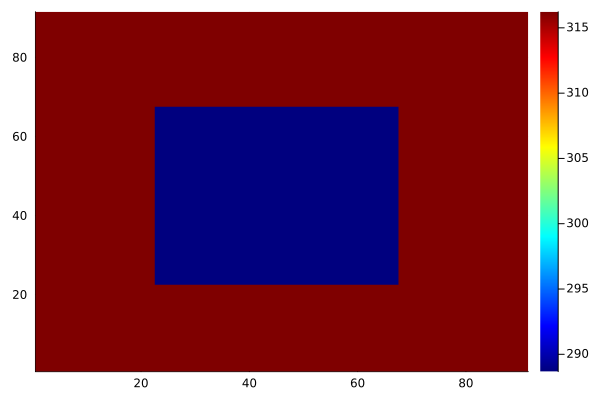

In [25]:
heatmap(c[:,1,:], c=:jet)

In [26]:
# Change tgrid according to dx for inhomogenous media
# c= 340 .*ones(nx,ny,nz);
# c[:,:,1:20].= 100;
dx= step(xgrid);
dy= step(ygrid);
dz= step(zgrid);
dt= dx/ maximum(c)* 0.1;
tgrid= 0:dt:0.04;
nt= length(tgrid);

In [27]:
p= zeros(Float32, nx, ny, nz, nt);
dp1= zeros(Float32, nx, ny, nz);
dp2= zeros(Float32, nx, ny, nz);
dp3= zeros(Float32, nx, ny, nz);

d2p1= zeros(Float32, nx, ny, nz);
d2p2= zeros(Float32, nx, ny, nz);
d2p3= zeros(Float32, nx, ny, nz);

dρ1= zeros(Float32, nx, ny, nz);
dρ2= zeros(Float32, nx, ny, nz);
dρ3= zeros(Float32, nx, ny, nz);

In [28]:
# T = nx ny nz nt
dρ1= zeros(nx, ny, nz)
dρ2= zeros(nx, ny, nz)
dρ3= zeros(nx, ny, nz)

dp1= zeros(nx, ny, nz)
dp2= zeros(nx, ny, nz)
dp3= zeros(nx, ny, nz)

function update_p!(p, dp1, dp2, dp3, dρ1, dρ2, dρ3, d2p1, d2p2, d2p3, c, ρ, nt, Δx, Δy, Δz, Δt, f)
    d2_x!(d2p1, p[:,:,:,nt-1], Δx)
    # d_x!(d2p1, dp, Δx)
    
    d2_y!(d2p2, p[:,:,:,nt-1], Δy)
    # d_y!(d2p2, dp, Δy)
    
    d2_z!(d2p3, p[:,:,:,nt-1], Δz)
    # d_z!(d2p3, dp, Δz)
    
    d_x!(dp1, p[:,:,:,nt-1], Δx)
    d_x!(dρ1, 1 ./ρ, Δx)
    
    d_y!(dp2, p[:,:,:,nt-1], Δy)
    d_y!(dρ2, 1 ./ρ, Δy)
    
    d_z!(dp3, p[:,:,:,nt-1], Δz)
    d_z!(dρ3, 1 ./ρ, Δz)
    
#     d2_x!(dp1, u[:,:,:,nt-1], Δx)
#     d2_y!(dp2, u[:,:,:,nt-1], Δy)
#     d2_z!(dp3, u[:,:,:,nt-1], Δz)
    p[:,:,:, nt].= 2 .*p[:,:,:, nt-1]- p[:,:,:, nt-2] .+ Δt*Δt.*c.*c.*(d2p1 .+ d2p2 .+d2p3)./ρ .+ Δt*Δt.*c.*c.*ρ.*(dρ1.*dp1 .+dρ2.*dp2 .+dρ3.*dp3) .+Δt*Δt.*c.*c.*ρ.*f[:,:,:,nt];

end

update_p! (generic function with 1 method)

In [29]:
# p[Int(round(nx/2)),1,Int(round(nz/2)),1]= 1.;
# u[:,1,2,1].= u[:1,1,1];
# u[]

src= zeros(nt);
src[1:100].= sin.((1:100)./100 *2π);
src_f= zeros(Float32, nx, ny, nz, nt);
src_f[Int(round(nx/2)), 1, Int(round(nz/2)), :].= src;

In [30]:
# u[Int(round(nx/4)):Int(round(3nx/4))-1,1,Int(round(nz/2)),1]= gaussian.(1:nx/2, 1, mean(1:nx/2), 2);
# u[Int(round(nx/2)),1,Int(round(nz/2)),1]= 1.;
# u[:,1,2,1].= u[:1,1,1];
# u[]

In [31]:
@showprogress for it in 3:nt
    # update_u!(p, dp, d2p1, d2p2, d2p3, c, ρ, it, dx, dy, dz, dt);
    update_p!(p, dp1, dp2, dp3, dρ1, dρ2, dρ3, d2p1, d2p2, d2p3, c, ρ, it, dx, dy, dz, dt, src_f);
    # if it==30 break; end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


In [32]:
anim= @animate for it in 1:10:nt
    heatmap(p[:,1,:,it]', yflip= true, title= "$it")#, clims= (-0.0025, 0.0025))
end

Animation("/var/folders/x1/3hy4wtvs4b33gn48_tg_n29w0311lh/T/jl_qqlGXm", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000118.png", "000119.png", "000120.png", "000121.png", "000122.png", "000123.png", "000124.png", "000125.png", "000126.png", "000127.png"])

┌ Info: Saved animation to /Users/asingh933/Desktop/wassup_danger/wave_simulation/Finite difference/acoustic.gif
└ @ Plots /Users/asingh933/.julia/packages/Plots/zzg7i/src/animation.jl:149


Plots.AnimatedGif("/Users/asingh933/Desktop/wassup_danger/wave_simulation/Finite difference/acoustic.gif")
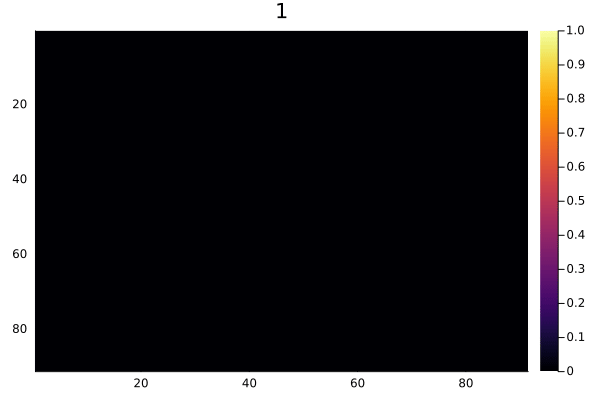

In [33]:
gif(anim, "acoustic.gif")